In [44]:
from matplotlib import pyplot as plt
import os
from scipy.io.wavfile import read
import scipy
import numpy as np
import torch
import librosa
from librosa.feature import melspectrogram
import scaleogram as scg 
from logmmse import logmmse_from_file
import pywt
import seaborn as sns
import pandas as pd
import sys
from AEspeech import AEspeech
from phonetGM2 import Phonet
from SpecDatset import SpecDataset

In [45]:
from SpecDatset import SpecDataset
import time
import torch
import numpy as np
import pandas as pd
import os
import sys
from CAE import CAEn
PATH=os.getcwd()
sys.path.append(PATH+"/toolbox/")
import traintestsplit as tts

In [33]:
PATH=os.getcwd()
path_audio=PATH+'/tedx_spanish_corpus/speech/test/'
wav_file=path_audio+os.listdir(path_audio)[0]

fs_in, signal=read(wav_file)

phon=Phonet()

#set loop parameters
rep='spec'
models=['CAE','RAE']
mod='CAE'
#     units=[]
unit=256
num_files=len(os.listdir(path_audio))

save_path=PATH+'/phonCSVs/'+rep+'/'

FS=16000
NFFT=512  
HOP=64

# for mod in models:
aespeech=AEspeech(model=mod,units=unit,rep=rep)
if rep=='spec':
    mat=aespeech.compute_spectrograms(wav_file)
    mat=aespeech.standard(mat)
if rep=='wvlt':
    mat=aespeech.compute_cwt(wav_file)

if torch.cuda.is_available():
    mat=mat.cuda()
to,bot=aespeech.AE.forward(mat)
# to=aespeech.destandard(to)
# mat=aespeech.destandard(mat)

spec_recon=to.cpu().data.numpy()
spec_ori=mat.cpu().data.numpy()

nf=spec_recon.shape[0]

fs_in, audio=read(wav_file)



# speech_recon=mel2speech(spec_recon)
# speech_ori=mel2speech(spec_ori)
    
# if not os.path.isdir(save_path):
#     os.makedirs(save_path)

# reconPath_phonSave=save_path+'/'+str(unit)+'_'+mod+'_recon.csv'
# oriPath_phonSave=save_path+'/'+str(unit)+'_'+mod+'_original.csv'    
# phon.get_phon_wav(speech_recon,feat_file=reconPath_phonSave,phonclass="all")
# phon.get_phon_wav(speech_ori,feat_file=oriPath_phonSave,phonclass="all")

#     print("processing file ", j+1, " from ", str(num_files), " ", hf[j])

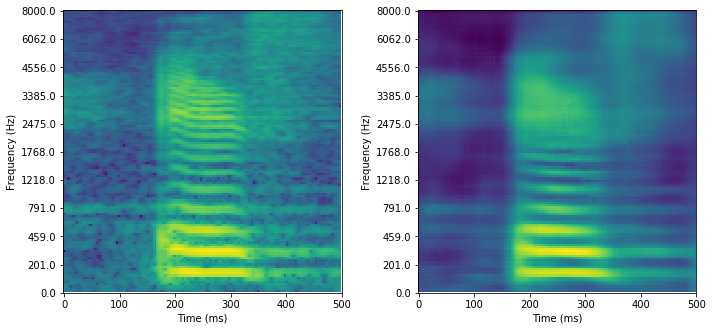

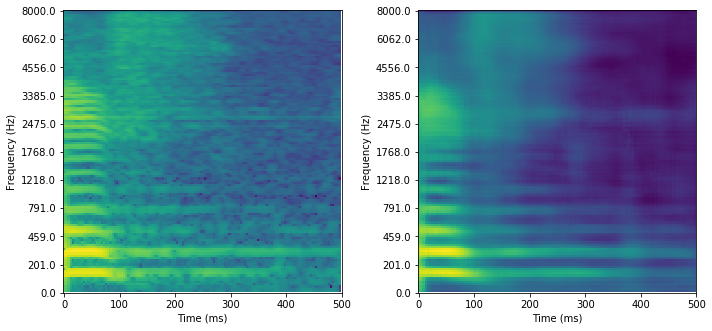

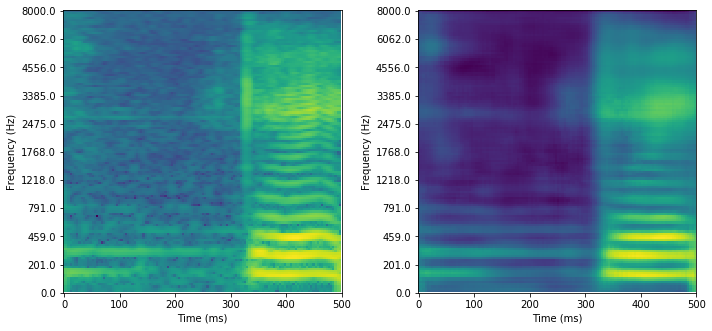

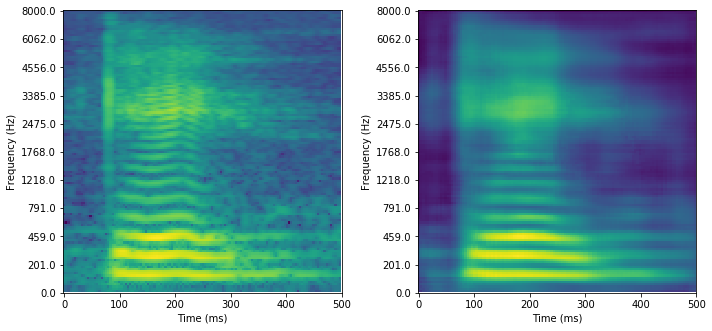

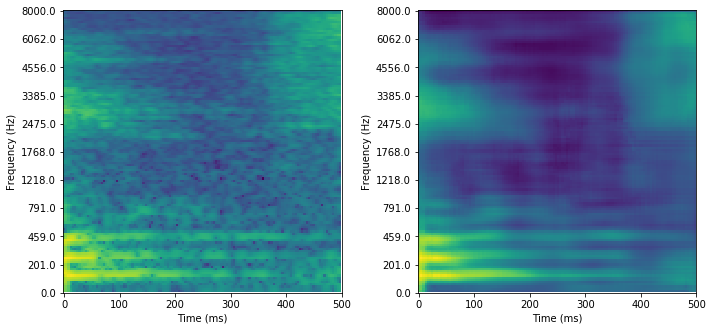

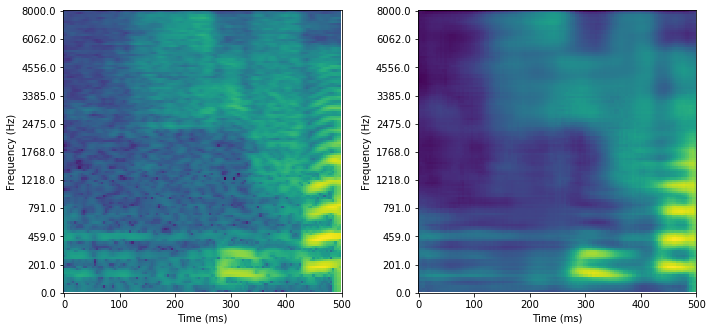

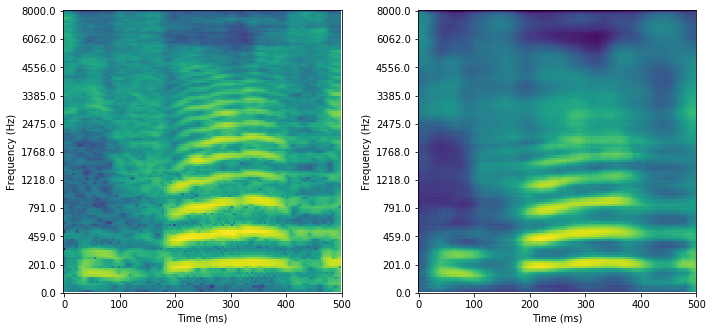

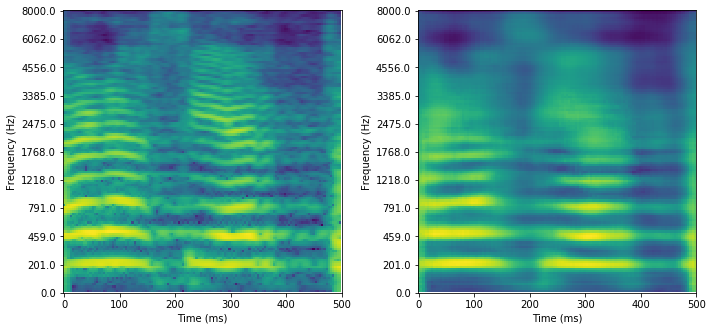

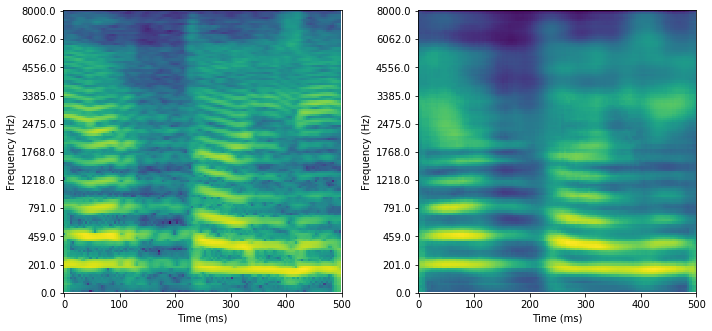

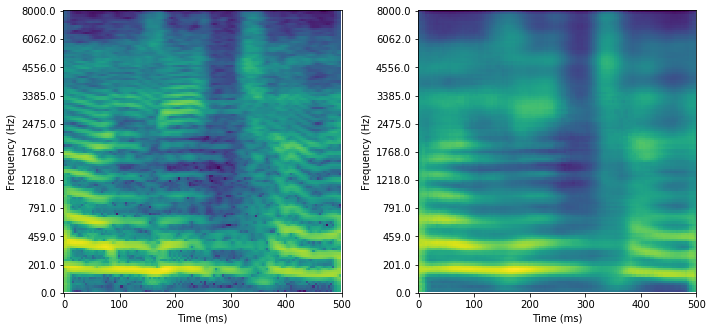

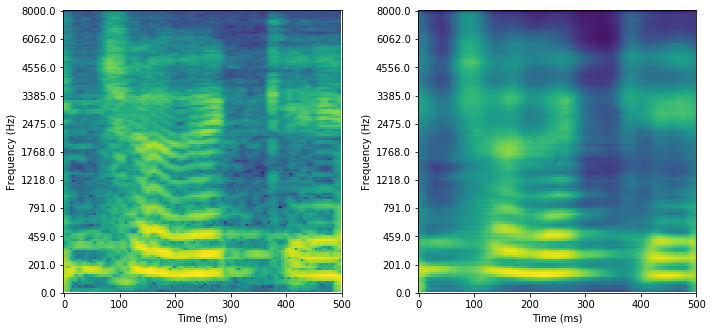

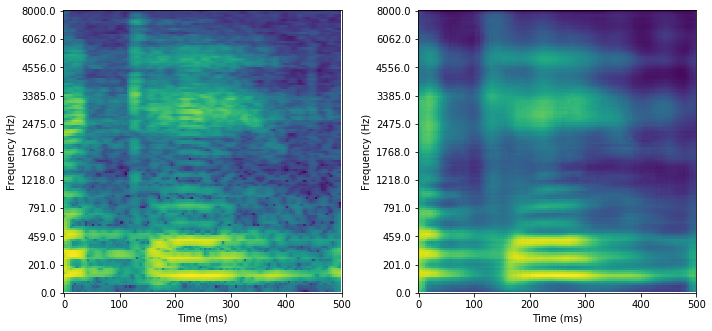

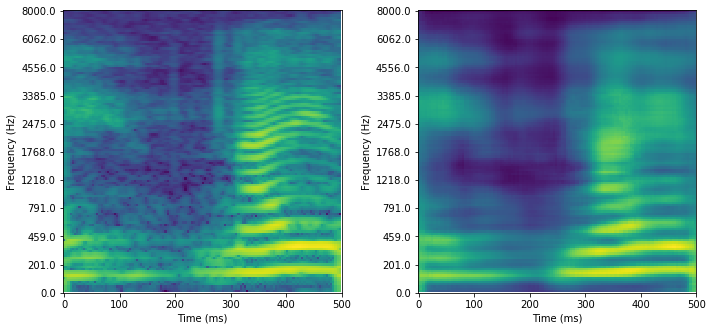

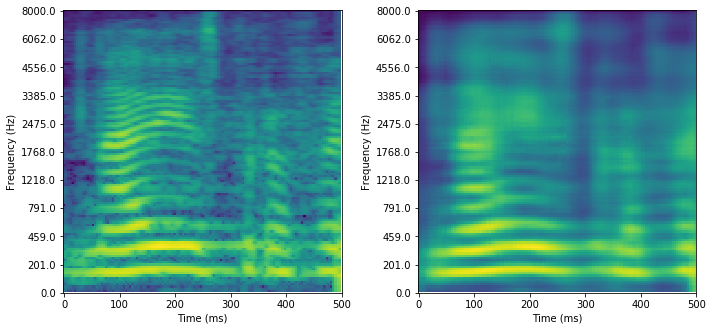

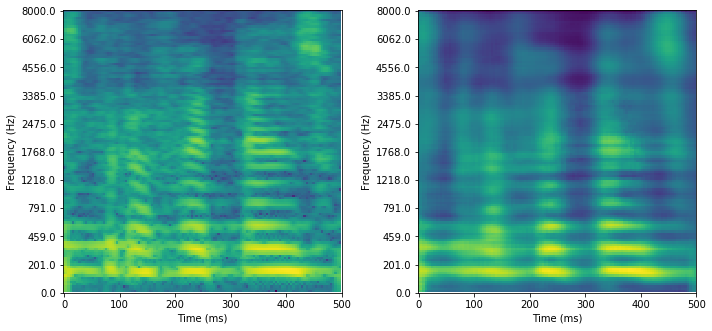

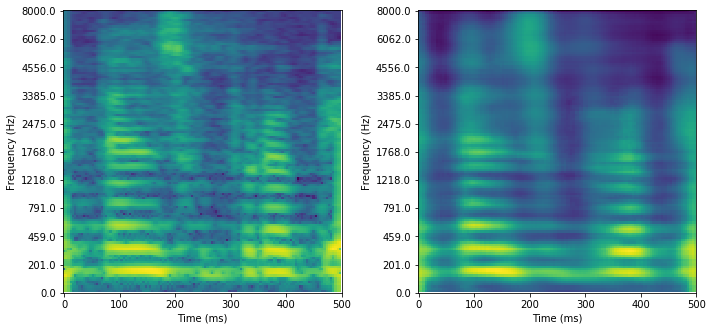

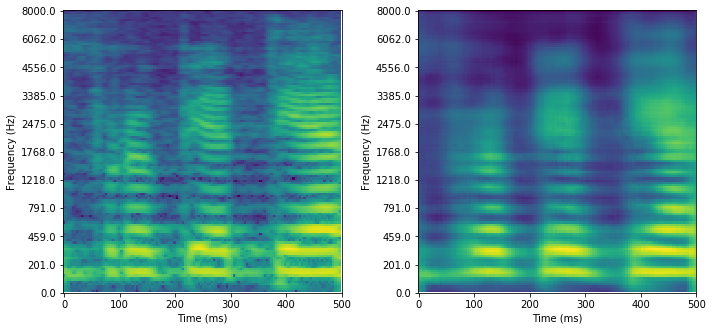

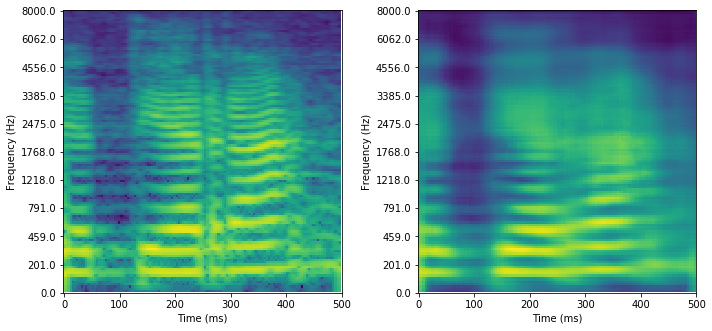

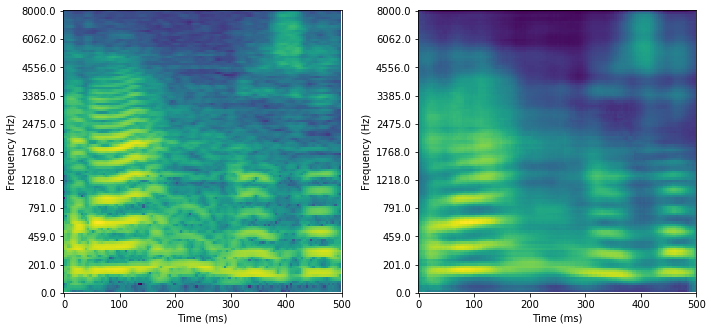

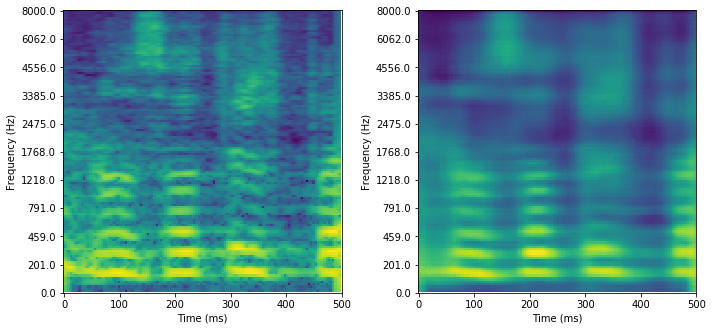

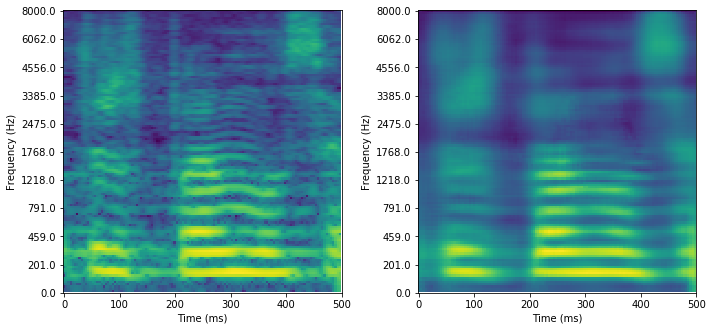

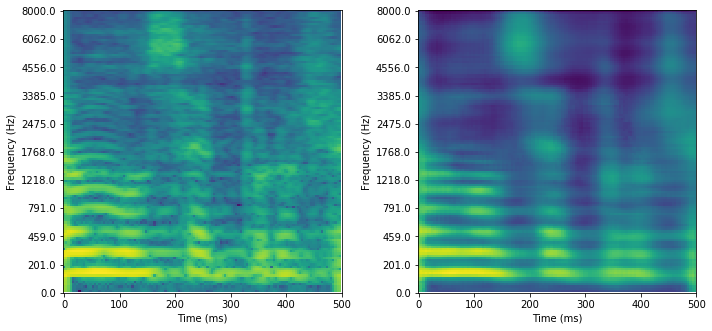

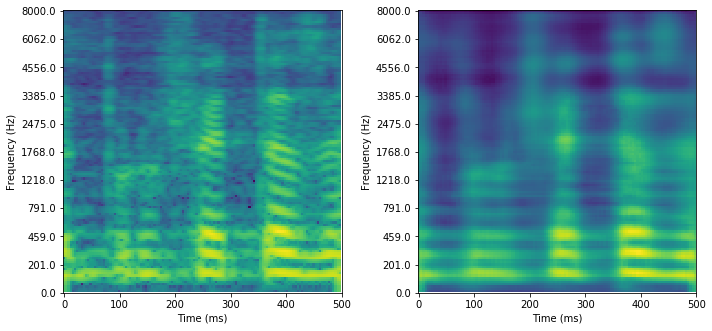

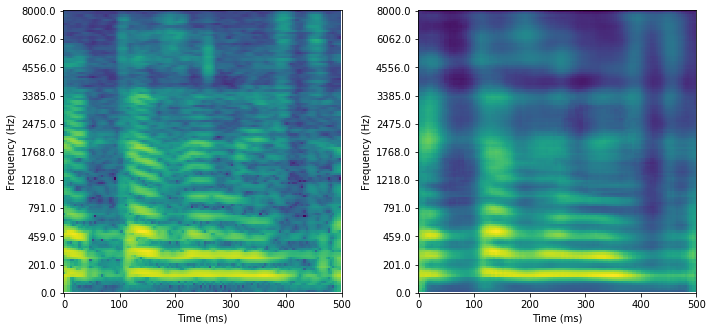

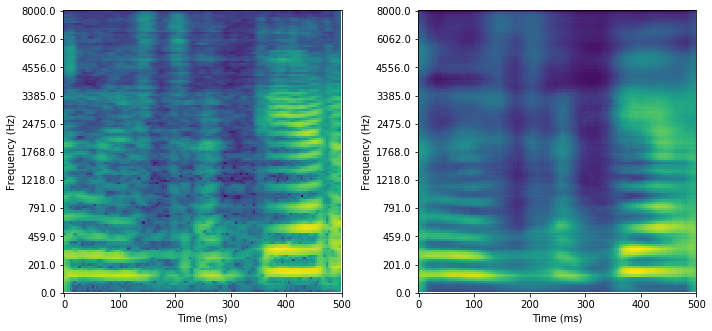

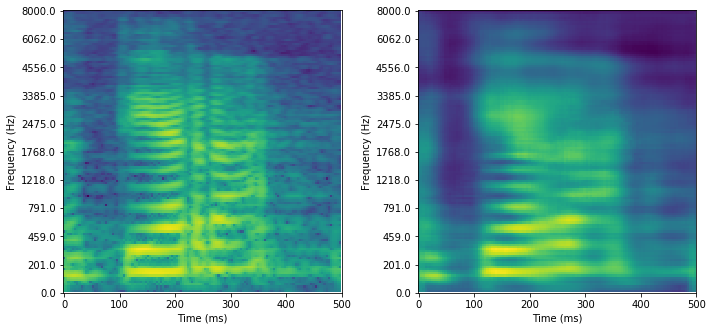

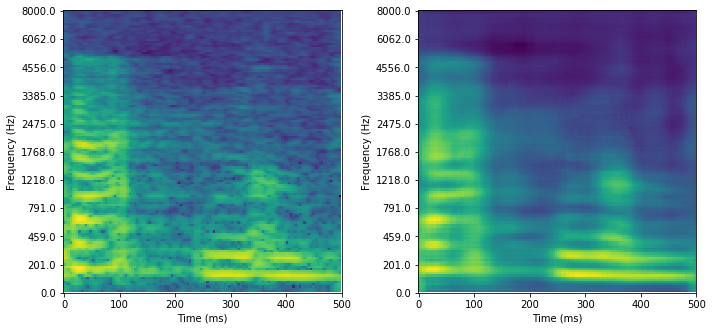

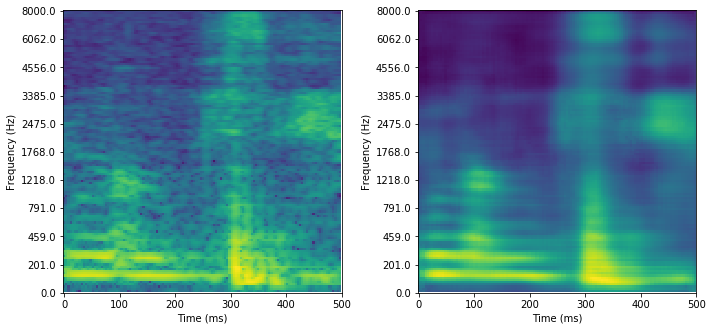

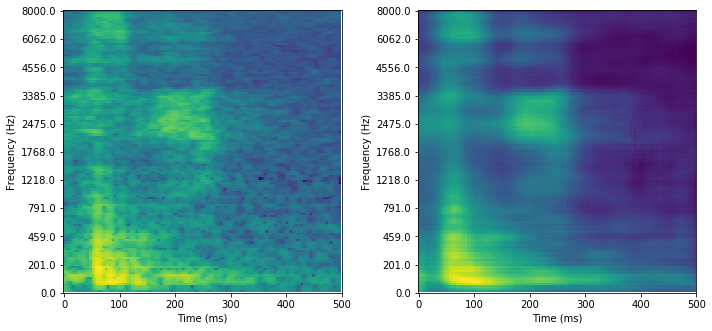

In [47]:
file_path=PATH+"/waveglow/mel_tests/"
files=file_path+os.listdir(file_path)[0]

aespeech.show_spectrograms(mat,to)



AttributeError: 'numpy.ndarray' object has no attribute 'set_yticks'

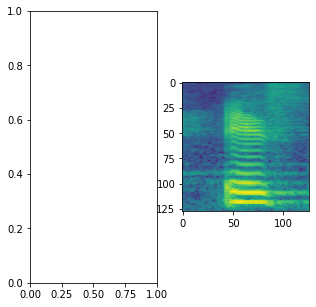

In [8]:
mmax=2595*np.log10(1+8000/700)
m=np.linspace(0,mmax,11)

f=np.round(700*(10**(m/2595)-1))
f=f[::-1]
for k in range(spec_ori.shape[0]):
    fig,ax=plt.subplots(1,2)
    fig.set_size_inches(5, 5)
    mat=spec_ori[k,0,:,:]
#     mat=spectrograms.data.numpy()[k,0,:,:]
    ax_curr=ax[]
    plt.imshow(np.flipud(mat), cmap=plt.cm.viridis, vmax=mat.max())
    ax.set_yticks(np.linspace(0,128,11))
    ax.set_yticklabels(map(str, f))
    ax.set_xticks(np.linspace(0,126,6))
    ax.set_xticklabels(map(str, np.linspace(0,500,6, dtype=np.int)))
    ax.set_ylabel("Frequency (Hz)")
    ax.set_xlabel("Time (ms)")
    plt.tight_layout()
    plt.show()
    


In [5]:
def dct(n_mfcc,n_mel):
    basis = np.empty((n_mfcc, n_mel))
    basis[0, :] = 1.0 / np.sqrt(n_mel)

    samples = np.arange(1, 2*n_mel, 2) * np.pi / (2.0 * n_mel)

    for i in range(1, n_mfcc):
        basis[i, :] = np.cos(i*samples) * np.sqrt(2.0/n_mel)

    return basis

def invlogamplitude(S):
    """librosa.logamplitude is actually 10_log10, so invert that."""
    return 10.0**(S/10.0)

In [6]:
def mel2speech(spec_sig):

    FS=16000
    NFFT=512

    spec_sig=np.squeeze(spec_sig,axis=1)
    nf=spec_sig.shape[0]
    n_mfcc=np.shape(spec_sig)[1]
    n_mel=np.shape(spec_sig)[2]

    dctm=dct(n_mfcc,n_mel)
    mel_basis=librosa.filters.mel(FS, NFFT)

    # Empirical scaling of channels to get ~flat amplitude mapping.
    bin_scaling=1.0/np.maximum(0.0005, np.sum(np.dot(mel_basis.T, mel_basis),axis=0))

    for k in range(nf):
    #         spec_sig_curr=np.squeeze(spec_sig[k,:,:],axis=0)
        spec_sig_curr=spec_sig[k,:,:]

        # Reconstruct the approximate STFT squared-magnitude from the MFCCs.
        if k==0:
            wav_stft=bin_scaling[:, np.newaxis] * np.dot(mel_basis.T,invlogamplitude(np.dot(dctm, spec_sig_curr.T)))
#             wav_stft=librosa.feature.inverse.mel_to_stft(spec_sig_curr,sr=16000, n_fft=512)
        else:
            wav_stft=np.append(wav_stft,librosa.feature.inverse.mel_to_stft(spec_sig_curr,sr=16000, n_fft=512),axis=1)
#             wav_stft=np.append(wav_stft,bin_scaling[:, np.newaxis] * np.dot(mel_basis.T,invlogamplitude(np.dot(dctm, spec_sig_curr.T))),axis=1)

    # Impose reconstructed magnitude on white noise STFT.
    excitation=np.random.randn(FS)
    E=librosa.stft(excitation, n_fft=512)
    #     if k==0:
    speech_sig=librosa.core.griffinlim(np.dot((E/np.abs(E)).T,np.sqrt(wav_stft)).T)

    sig_size=speech_sig.shape[0]
    fr_samples=sig_size//(2*nf)
    leftover=sig_size%fr_samples

    output_speech_sig=np.zeros((fr_samples*(nf+1))+leftover)

    c_idx=0

    for k in range(nf):
        if k==nf-1:
            output_speech_sig[c_idx:]=speech_sig[c_idx*2:]
        else:
            output_speech_sig[c_idx:c_idx+fr_samples]=speech_sig[c_idx*2:c_idx*2+fr_samples]
            c_idx+=fr_samples


    return output_speech_sig


#     else:
# #         old_sig=speech_sig[c_idx:TIME_SHIFT]
#         speech_sig=np.append(speech_sig,librosa.istft(np.dot((E/np.abs(E)).T,np.sqrt(wav_stft)).T))

# return speech_sig 

# Output
# librosa.output.write_wav('output.wav', ori_speech, sr)

In [ ]:
# librosa.output.write_wav('output.wav', speech_sig, FS)
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.plot(speech_recon)

plt.subplot(3,1,2)
plt.plot(speech_ori)

plt.subplot(3, 1, 3)
plt.plot(signal)

In [12]:
def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in np.arange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start:stop]

    return out

def stft(
    X, fftsize=128, step=65, mean_normalize=True, real=False, compute_onesided=True
):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10):
    
    old_settings = np.seterr(over='ignore')
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1e5
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype("float64")
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print(
                    "WARNING: Large step size >50\% detected! "
                    "This code works best with high overlap - try "
                    "with 75% or greater"
                )
                offset_size = step
            offset = xcorr_offset(
                wave[wave_start : wave_start + offset_size],
                wave_est[est_start : est_start + offset_size],
            )
        else:
            offset = 0
        wave[wave_start:wave_end] += (
            win * wave_est[est_start - offset : est_end - offset]
        )
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1e-6)
    return wave


def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype("float32"), x2[::-1].astype("float32"))
    corrs[:half] = -1e30
    corrs[-half:] = -1e30
    offset = corrs.argmax() - len(x1)
    return offset


def make_mel(spectrogram, mel_filter, shorten_factor=1):
    mel_spec = np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(
        mel_spec.astype("float32"), [1, 1.0 / shorten_factor]
    ).astype("float16")
    mel_spec = mel_spec[:, 1:-1]  # a little hacky but seemingly needed for clipping
    return mel_spec


def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = mel_spec + spec_thresh
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(
        uncompressed_spec.astype("float32"), [1, shorten_factor]
    ).astype("float16")
    uncompressed_spec = uncompressed_spec - 4
    return uncompressed_spec


# From https://github.com/jameslyons/python_speech_features


def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1 + hz / 700.0)


def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700 * (10 ** (mel / 2595.0) - 1)


def get_filterbanks(nfilt=20, nfft=512, samplerate=16000, lowfreq=0, highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq = highfreq or samplerate / 2
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft + 1) * mel2hz(melpoints) / samplerate)

    fbank = np.zeros([nfilt, nfft // 2])
    for j in range(0, nfilt):
        for i in range(int(bin[j]), int(bin[j + 1])):
            fbank[j, i] = (i - bin[j]) / (bin[j + 1] - bin[j])
        for i in range(int(bin[j + 1]), int(bin[j + 2])):
            fbank[j, i] = (bin[j + 2] - i) / (bin[j + 2] - bin[j + 1])
    return fbank


def create_mel_filter(
    fft_size, n_freq_components=64, start_freq=300, end_freq=8000, samplerate=16000
):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(
        nfilt=n_freq_components,
        nfft=fft_size,
        samplerate=samplerate,
        lowfreq=start_freq,
        highfreq=end_freq,
    )
    # Normalize filter
    ax1_sum=np.where(mel_inversion_filter.sum(axis=1)==0, mel_inversion_filter.sum(axis=1)==0, 0.005)
    mel_filter = mel_inversion_filter.T / ax1_sum

    return mel_filter, mel_inversion_filter

In [14]:
import copy
spec_thresh=4
shorten_factor=10

mel_filter, mel_inversion_filter = create_mel_filter(
    fft_size=NFFT,
    n_freq_components=128,
    start_freq=0,
    end_freq=8000,
)

mel_inverted_spectrogram = mel_to_spectrogram(
    spec_ori[4,0,:,:],
    mel_inversion_filter,
    spec_thresh=spec_thresh,
    shorten_factor=shorten_factor,
)

inverted_mel_audio = invert_pretty_spectrogram(
    np.transpose(mel_inverted_spectrogram),
    fft_size=512,
    step_size=32,
    log=True,
    n_iter=10,
)

FloatingPointError: invalid value encountered in true_divide

In [ ]:
# def mel2speech(spec_signal):
# spec_signal= spec_ori
# feats = librosa.feature.mfcc(S=librosa.power_to_db(spec_ori), n_mfcc=spec_ori.shape[0])
# FRAME_SIZE=0.5
# TIME_SHIFT=0.25
# OVRLAP=FRAME_SIZE/TIME_SHIFT
# FS=16000
# NFFT=512  
# HOP=64

# signal=signal-np.mean(signal)
# signal=signal/np.max(np.abs(signal))
# init=0
# endi=int(FRAME_SIZE*self.fs)
# nf=spec_signal.shape[0]
# signal_len=(nf+1)*(TIME_SHIFT*FS)
# spec_signal=np.squeeze(spec_signal,axis=1)

# j=0
# for k in range(nf):
#     try:
# #         sig_curr=np.squeeze(spec_signal[k,:,:],axis=0)
#         sig_curr=spec_signal[k,:,:]
#         inv_imag=librosa.feature.inverse.mel_to_stft(sig_curr,sr=FS,n_fft=NFFT, hop_length=HOP)
        
#         frame=signal[init:endi]
#         imag=melspectrogram(frame, sr=self.fs, n_fft=NFFT, hop_length=HOP, n_mels=self.nmels, fmax=self.fs/2)
#         init=init+int(TIME_SHIFT*self.fs)
#         endi=endi+int(TIME_SHIFT*self.fs)
#         if np.min(np.min(imag))<=0:
#             warnings.warn("There is Inf values in the Mel spectrogram")
#             continue
#         imag=np.log(imag, dtype=np.float32)
#         imagt=torch.from_numpy(imag)
#         mat[j,:,:,:]=imagt
#         j+=1
        
# spec_signal=spec_signal.reshape(spec_signal.shape[1],-1)
# spec_signal=np.squeeze(spec_signal,axis=1)
# speech_signal=librosa.feature.inverse.mel_to_stft(spec_signal,128)
# speech_signal
# speech_signal=np.array([])
# num_batches=np.shape(spec_signal)[0]

# return speech_signal

In [51]:
import wave

PATH=os.getcwd()
path_audio=PATH+'/tedx_spanish_corpus/speech/test/'
wav_file=path_audio+os.listdir(path_audio)[0]
fs, signal=read(wav_file)
FS=16000

obj = wave.open('sound.wav','w')
obj.setnchannels(1) # mono
obj.setsampwidth(2)
obj.setframerate(FS)
# for i in range(99999):
#    value = random.randint(-32767, 32767)
#    data = struct.pack('<h', value)
obj.writeframesraw(speech_ori)
obj.close()

In [ ]:
aespeech=AEspeech("CAE", 256, rep='wvlt') # load the pretrained CAE with 256 units
# mat_spec=aespeech.compute_spectrograms(wav_file) # compute the decoded spectrograms from the autoencoder
# print(mat_spec.size())
# aespeech.show_spectrograms(mat_spec)

coefs,freqs=aespeech.compute_cwt(wav_file,volta=2)
time=np.arange(np.shape(coefs)[1])
ax=aespeech.show_scalogram(time,coefs,freqs, yaxis='frequency')

In [7]:
def logmmseDenoise(x):

#     x=speech_ori

    #Define frame size, time shift in terms of samples
    FRAME_SIZE=500  
    TIME_SHIFT=250
    NFFT=512
    FS=16000
    win=np.hamming(FRAME_SIZE) 

    x_old=np.zeros((TIME_SHIFT,NFFT))  
    Nframes=int(np.floor(len(x)/TIME_SHIFT)-(FRAME_SIZE/TIME_SHIFT)) 
    xfinal=np.zeros((Nframes*TIME_SHIFT,NFFT))

    noise_mean=np.zeros((NFFT,1))  
    j=0  
    for m in range(2):
        noise_mean=noise_mean+abs(scipy.fft(np.multiply(win,x[j:j+FRAME_SIZE]),NFFT))
        j=j+FRAME_SIZE  

    noise_mu=noise_mean/6  
    noise_mu2=noise_mu**2  

    k=0  
    aa=0.98  
    mu=0.98  
    eta=0.15   

    ksi_min=10**(-25/10)  

    nf=int(len(x)/(TIME_SHIFT*FS))-1
    
    for n in range(nf):

        insign=np.multiply(win,x[k:k+FRAME_SIZE])  

        #compute magnitude square of fft
        spec=scipy.fft(insign,NFFT) 
        sig=abs(spec)  
        sig2=sig**2  

        # limit post SNR to avoid overflows
        gammak=np.divide(sig2,noise_mu2)
        gammak=np.where(gammak>40,40,gammak)


        temp_gammak=gammak-1
        temp_gammak=np.where(temp_gammak<0,0,temp_gammak)
        if n==0:  
            ksi=aa+np.multiply((1-aa),temp_gammak)
        else:  
            #a-priori SNR with ksi limited to -25 dB
            ksi=np.divide(aa*Xk_prev,noise_mu2) + np.multiply((1-aa),temp_gammak)
            ksi=np.where(ksi<ksi_min,ksi_min,ksi)
    #         ksi=[max(ksi_min,k) for ks in ksi for k in ks]     

        log_sigma_k=np.divide(gammak,np.divide(ksi,(1+ ksi)- np.log(1+ ksi)))      
        vad_decision= np.divide(sum(log_sigma_k),FRAME_SIZE)      

        #If only noise in frame found
        if np.all(vad_decision<eta):   
            noise_mu2=mu*noise_mu2+(1-mu)*sig2

        #Log-MMSE estimator  
        A=np.divide(ksi,(1+ksi)) 
        vk=np.multiply(A,gammak)  
        ei_vk=0.5*scipy.special.exp1(vk)  
        hw=np.multiply(A,np.exp(ei_vk))

        sig=np.multiply(sig,hw)  
        Xk_prev=sig**2  

        xi_w=scipy.ifft(np.multiply(hw,spec),NFFT)  
        xi_w=np.real(xi_w)

        xfinal[:TIME_SHIFT]=x_old+xi_w[:TIME_SHIFT]
        x_old=xi_w[TIME_SHIFT:FRAME_SIZE]

        k=k+TIME_SHIFT

    return xfinal

In [ ]:
mat=aespeech.compute_cwt(wav_file,volta=1)
# mat=aespeech.standard(mat)
if torch.cuda.is_available():
    mat=mat.cuda()
to,bot=aespeech.AE.forward(mat)
# to=aespeech.destandard(to)

recon=to.data.numpy()
ori=mat.data.numpy()

recon=np.reshape(recon,(np.shape(recon)[2:]))
ori=np.reshape(ori,(np.shape(ori)[2:]))

In [ ]:
time=np.arange(np.shape(recon)[-1])
ax=aespeech.show_scalogram(time,ori,freqs)

In [ ]:
time=np.arange(np.shape(recon)[-1])
ax=aespeech.show_scalogram(time,recon,freqs)

In [ ]:
SAMPLE_PERIOD = 3200
HOP = 20
fs,data=read(wav_file)

time=np.arange(data.shape[0s])
scales = np.arange(1, SAMPLE_PERIOD, HOP)*pywt.central_frequency('morl')
                                                                 

In [ ]:
cwt= scg.CWT(time,data,scales)
cmp_coefs=cwt.coefs
freqs=cwt.scales_freq
# coefs, freqs = pywt.cwt(data, scales, 'morl')
np.abs(cmp_coefs)

In [ ]:
# mat_spec=aespeech.compute_spectrograms(wav_file) # compute the decoded spectrograms from the autoencoder
# print(mat_spec.size())
# aespeech.show_spectrograms(mat_spec)
aespeech.min_scaler

In [ ]:
SAMPLE_PERIOD = 3200
HOP = 25
# coefs = wv_coefs.data.numpy()[0,0,:,:]

# signal=pywt.icwt(coefs, None, 'morl', 'smooth')
uns_signal_length = np.shape(signal)[0]


signal_new = signal_new - np.mean(signal_new)
signal_new = signal_new/np.max(np.abs(signal_new))
signal_new_length = np.shape(signal_new)[0]
xtix = np.array((np.arange(uns_signal_length)/16000))

# range of scales to perform the transform
scales = np.arange(1, SAMPLE_PERIOD, HOP)*pywt.central_frequency('morl')

ax2 = scg.cws(signal_new[:signal_new_length], scales=scales, figsize=(10, 4.0), yscale = 'log', coi = False, ylabel="Period", xlabel="Time (s)")
#         ax2.set_title=wav_file.split('/')[-1]
ax2.set_xticks(np.arange(0,16000,signal_new_length//np.ceil(xtix[-1])))
ax2.set_xticklabels(np.round(xtix[::int(uns_signal_length//int(np.ceil(xtix[-1])))],2))

In [ ]:
# choose default wavelet function 
waveletype = 'morl'
sample_period = 3200
hop = 64
fs_new = 16000

signal_new = signal_new - np.mean(signal_new)
signal_new = signal_new/np.max(np.abs(signal_new))

# range of scales to perform the transform
scales =  np.arange(1, sample_period, hop)*pywt.central_frequency(waveletype)
coefs, freqs = pywt.cwt(signal_new, scales, waveletype)

In [ ]:
# choose default wavelet function 
waveletype = 'morl'

fs_new = 16000
signal_new = signal - np.mean(signal)
signal_new = signal_new/np.max(np.abs(signal_new))
signal_new_length = np.shape(signal_new)[0]
uns_signal_length = np.shape(signal)[0]
xtix = np.array((np.arange(uns_signal_length)/fs))


# range of scales to perform the transform
scales = np.logspace(np.log10(2), np.log10(3200), 64)*pywt.central_frequency(waveletype)


x_values_wvt_arr = range(0,signal_new_length,1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, signal_new[:signal_new_length], linewidth=3, color='blue')
ax1.set_xlim(0, signal_new_length)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Normalized Freq. (Hz)")
ax1.set_title(wav_file.split('/')[-1])
ax1.set_xticks(np.arange(0,fs_new,signal_new_length//np.ceil(xtix[-1])))
ax1.set_xticklabels(np.round(xtix[0:-1:int(uns_signal_length//int(np.ceil(xtix[-1])))],2))

# the scaleogram
ax2 = scg.cws(signal_new[:signal_new_length], scales=scales, figsize=(10, 4.0), yscale = 'log',coi = False, ylabel="Period", xlabel="Time (s)",
        title=wav_file.split('/')[-1])
ax2.set_xticks(np.arange(0,fs_new,signal_new_length//np.ceil(xtix[-1])))
ax2.set_xticklabels(np.round(xtix[::int(uns_signal_length//int(np.ceil(xtix[-1])))],2))
